In [1]:
import os
import sys
sys.path.append('..')
import pickle
import os.path as op
import pandas as pd
import numpy as np
import scipy.io as sio
import scipy.signal as ss
import scipy.stats as st
import scipy.ndimage as sn
import matplotlib.pyplot as plt
from source.ERPDecoders import ERP_Decode_SK

In [2]:
# load data files
subj = 'cc'
ecog_path = ['.', 'data', subj, '{}_fingerflex.mat'.format(subj)]
ecog_file = op.join(*ecog_path) # use * to unpack the list
ecog = sio.loadmat(ecog_file)

stim_path = ['.', 'data', subj, '{}_stim.mat'.format(subj)]
stim_file = op.join(*stim_path) # use * to unpack the list
stim = sio.loadmat(stim_file)

In [334]:
ecog.keys()

dict_keys(['__header__', '__version__', '__globals__', 'data', 'elec_regions', 'flex', 'brain', 'locs', 'cue'])

In [3]:
from nilearn import plotting
from nimare import utils

plt.figure(figsize=(8, 8))
locs = ecog['locs']
view = plotting.view_markers(utils.tal2mni(locs),
                             marker_labels=['%d'%k for k in np.arange(locs.shape[0])],
                             marker_color='purple',
                             marker_size=5)
view

<Figure size 800x800 with 0 Axes>

In [5]:
# create zscore function with dimension parameter
def zscore(x, dim):
    return (x - np.mean(x, axis=dim, keepdims=True))/np.std(x, axis=dim, keepdims=True)

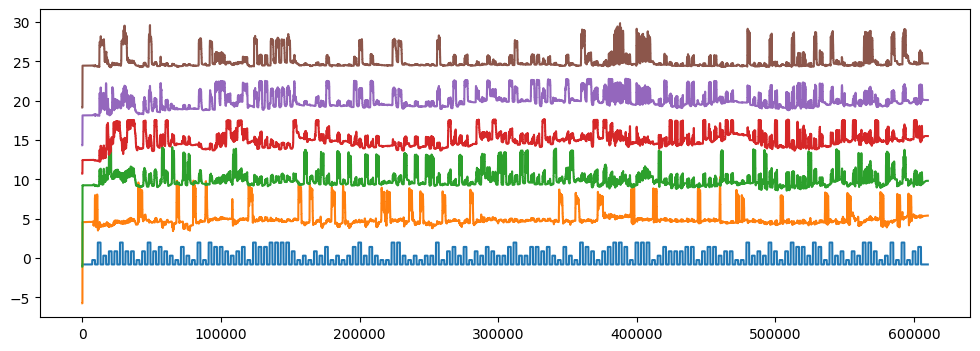

In [6]:
plt.figure(figsize=(12, 4))
plt.plot(zscore(ecog['cue'],0))
plt.plot(zscore(ecog['flex'],0)+np.arange(1,6)*5)

(19000.0, 23000.0)

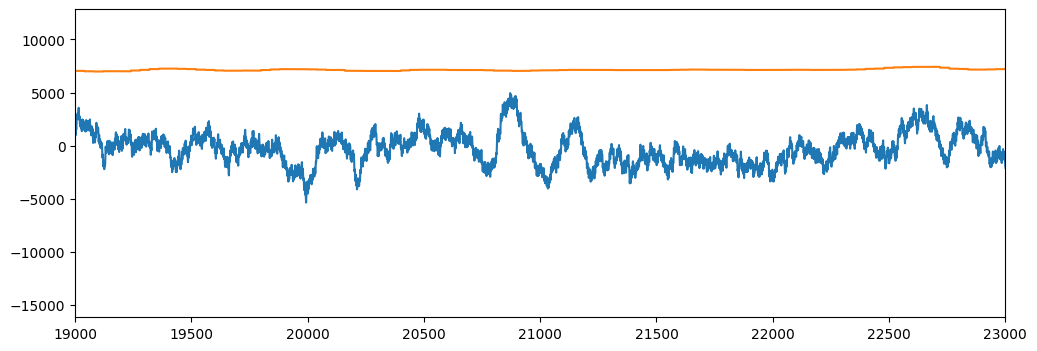

In [7]:
fig, ax = plt.subplots(figsize=(12, 4))
plt.plot(ecog['data'][:, 35])
plt.plot(ecog['flex'][:, 0]*5)
plt.xlim(19000, 23000)

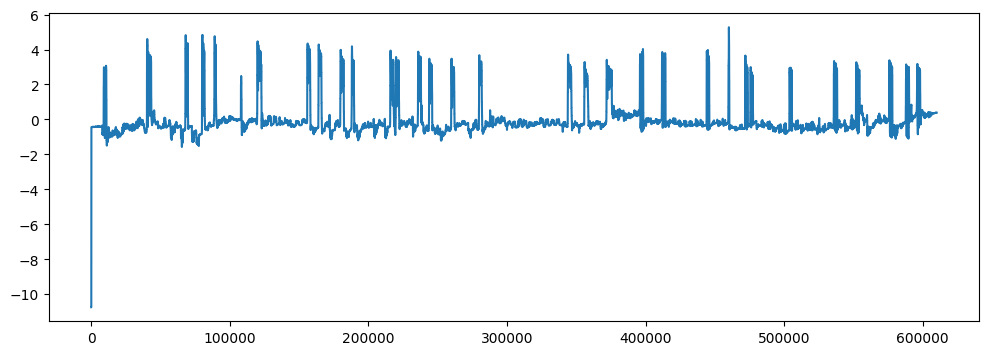

In [8]:
fig, ax = plt.subplots(figsize=(12, 4))
plt.plot((ecog['flex'][:, 0]-np.mean(ecog['flex'][:, 0]))/np.std(ecog['flex'][:, 0]))
#plt.xlim(100000, 130000)

In [9]:
fs = 1000
t_raw = np.arange(ecog['data'].shape[0])/fs
ch_list = np.arange(ecog['data'].shape[1])
fl_list = np.arange(ecog['flex'].shape[1])

In [10]:
#freqs, times, Sxx = ss.spectrogram(ecog['data'][:, 38], fs, nperseg=256, noverlap=200)
# use scipy.signal.spectrogram to get the spectrogram for each ecog channel
# store as a numpy array with dimensions (freqs, time, channels)
spec = []
for ch in ch_list:
    freqs, t_spec, Sxx = ss.spectrogram(ecog['data'][:, ch], fs, nperseg=256, noverlap=200, window='hamming')
    spec.append(Sxx.T) # transpose to get (time, freqs)
spec = np.dstack(spec)
spec.shape

(10890, 129, 63)

In [11]:
# detect when flex events are occurring
# 1. get the z-scored flex signal
# 2. detect when signal crosses a threshold
# 3. merge events using morphological closing operation

def detect_flex_events(flex_sig, thresh, spacing):
    """
    Detects events in a flex signal.
    
    Parameters
    ----------
    flex_sig : array_like
        The flex signal to detect events in.
    thresh : float
        The threshold to use for event detection.
    spacing : int
        The number of samples to merge events within.
        
    Returns
    -------
    events : array_like
        Binary array.
    """
    # 1. get the z-scored flex signal
    z_sig = (flex_sig - np.mean(flex_sig)) / np.std(flex_sig)
    # 2. detect when signal crosses a threshold
    events = z_sig > thresh
    # 3. merge events using morphological closing operation
    events = sn.binary_closing(events, structure=np.ones(spacing))
    return events



In [12]:
# detect when flex events are occurring
fl = []
for fl_ch in fl_list:
    fl.append(detect_flex_events(ecog['flex'][:, fl_ch], 1.5, 300))
fl = np.vstack(fl).T

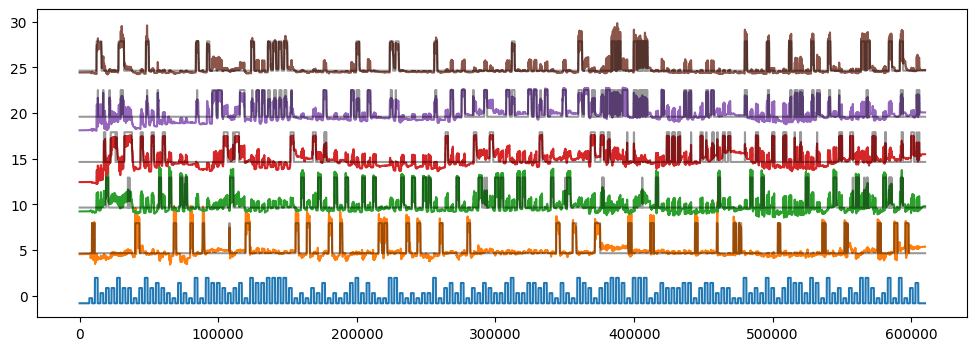

In [13]:
plt.figure(figsize=(12, 4))
plt.plot(zscore(ecog['cue'][100:],0))
plt.plot(zscore(ecog['flex'][100:],0)+np.arange(1,6)*5)

plt.plot(zscore(fl[100:], 0)+np.arange(1,6)*5, 'k', alpha=0.4)


In [14]:
# create a new array of fl events at the time points closest to those in the spectrogram data
fl_spec = np.zeros((spec.shape[0], fl.shape[1])).astype(int)

for i,t in enumerate(t_spec):
    fl_spec[i] = fl[np.argmin(np.abs(t_raw - t))]

In [15]:
sel_flex = 0

In [16]:
# get the onset times for the first type of flex events
onsets_spec = np.where(np.diff(fl_spec[:, sel_flex])>0)[0]
onsets = np.where(np.diff(fl[:, sel_flex].astype(int))>0)[0] # convert to int to avoid type error, diff of boolean only gives 1 for -1 or 1

(64.0, 74.0)

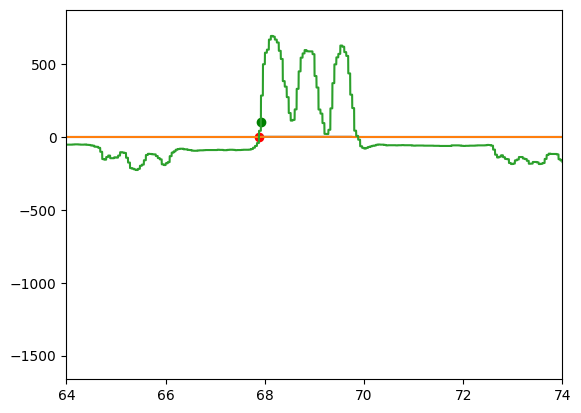

In [17]:
plt.plot(t_spec, fl_spec[:, sel_flex])
plt.plot(t_raw, fl[:, sel_flex])
plt.plot(t_raw, ecog['flex'][:,sel_flex]-np.mean(ecog['flex'][:,sel_flex]))
plt.scatter(t_spec[onsets_spec], np.ones(onsets_spec.shape), c='r')
plt.scatter(t_raw[onsets], np.ones(onsets.shape)+100, c='g')
plt.xlim(np.array([15,25])+49)


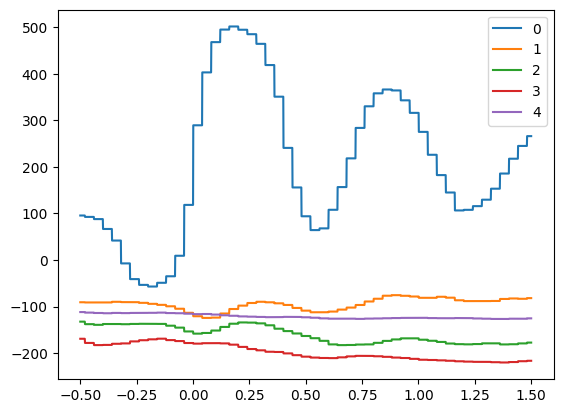

In [18]:
# calculate the mean flex response at the event onset times
fs = 1000
pre = int(0.5*fs)
post = int(1.5*fs)
events_fl = []
sel_fl = ecog['flex']-np.mean(ecog['flex'],0).reshape(1,-1)
for i, o in enumerate(onsets):
    events_fl.append(sel_fl[(o-pre):(o+post),:])
events_fl = np.stack(events_fl, axis=2)
events_fl_mean = np.mean(events_fl, axis=2)
# plot the mean evoked response
t = np.linspace(-0.5, 1.5, pre+post)
plt.plot(t, np.mean(events_fl,axis=2),label=np.arange(events_fl.shape[1]))
plt.legend()

In [19]:
plot_chan = 20
plot_trial = 12
pre_t = 1.5 # seconds
post_t = 1.5 # seconds

In [20]:
# preprocess spectrogram data
spec_pro = zscore(spec, 0)

# get the spectrogram data for each event
fs_spec = 1/np.mean(np.diff(t_spec))
pre = int(pre_t*fs_spec)
post = int(post_t*fs_spec)
spec_events = []
for i, o in enumerate(onsets_spec):
    spec_events.append(spec_pro[(o-pre):(o+post), :, :])

spec_events = np.stack(spec_events, axis=3)

spec_mean = np.mean(spec_events, axis=3)
spec_events_t = np.linspace(-pre_t, post_t, pre+post)

In [21]:
# preprocess ecog data
ecog_pro = zscore(ecog['data'], 0)

# calculate the mean evoked response at the event onset times
fs = 1000
pre = int(1.5*fs)
post = int(1.5*fs)
events = []
for i, o in enumerate(onsets):
    events.append(ecog_pro[(o-pre):(o+post), :])
events = np.stack(events, axis=2)

# get epochs 2 seconds offset from the event onset
null_events = []
for i, o in enumerate(onsets+(2*fs)):
    null_events.append(ecog_pro[(o-pre):(o+post), :])
null_events = np.stack(null_events, axis=2)

# calculate the mean evoked response at the event onset times
events_mean = np.mean(events, axis=2)
null_events_mean = np.mean(null_events, axis=2)
t = np.linspace(-pre_t, post_t, pre+post)


In [22]:
events.shape

(3000, 63, 47)

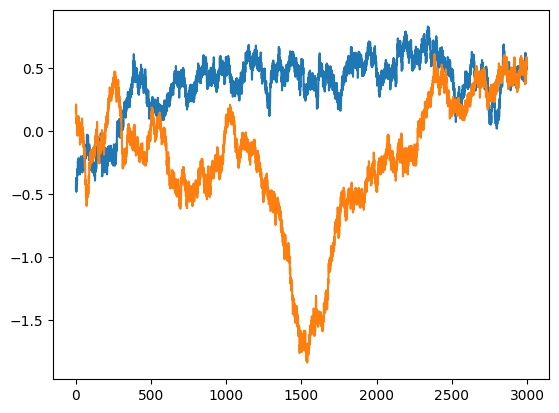

In [23]:
plt.plot(null_events_mean[:, plot_chan])
plt.plot(events_mean[:, plot_chan])

In [24]:
car = np.median(events,1)
car = car[:, np.newaxis, :]
car.shape

(3000, 1, 47)

In [29]:
np.random.choice(labels, size=labels.size, replace=False)

array([0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0.,
       0., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0.,
       1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0.,
       1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 1., 1., 1., 0., 1., 1., 0., 0.])

In [51]:
erp_decode = ERP_Decode_SK(k=3)
epochs = np.vstack([events[:,plot_chan,:].T, null_events[:,plot_chan,:].T])
labels = np.hstack([np.ones(events.shape[2]), np.zeros(null_events.shape[2])])
erp_decode.fit(epochs, labels)


(91.93548387096774, 90.625)

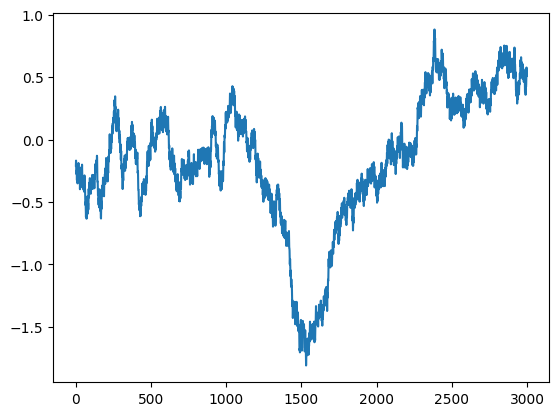

In [48]:
plt.plot(erp_decode.erp)

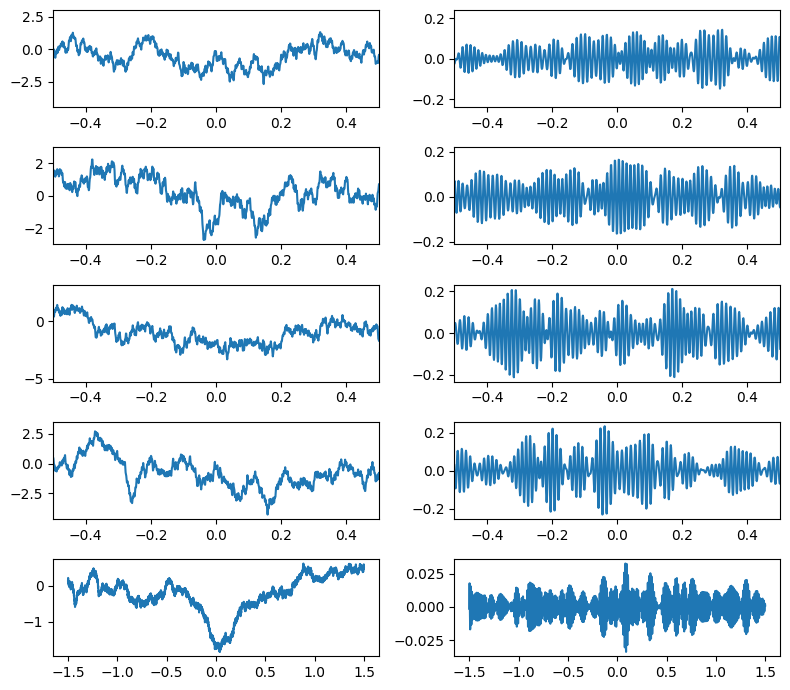

In [214]:
b, a = ss.butter(4, [70, 90], 'bandpass', fs=fs) # create the filter coefficients
events_filt = ss.filtfilt(b, a, events, axis=0) # filter the data

examp_trials = np.array([0, 1, 2, 3])
z_range = 5
mos_layout = [['ecog1', 'filt1'], ['ecog2', 'filt2'], ['ecog3', 'filt3'], ['ecog4', 'filt4'], ['ecog_mean', 'filt_mean']]
fig, ax = plt.subplot_mosaic(mos_layout, figsize=(8, 7))
for i, tr in enumerate(examp_trials):
    ax['ecog{}'.format(i+1)].plot(t, events[:, plot_chan, tr])    
    ax['ecog{}'.format(i+1)].set_xlim(-.5, .5)
    ax['filt{}'.format(i+1)].plot(t, events_filt[:, plot_chan, tr])    
    ax['filt{}'.format(i+1)].set_xlim(-.5, .5)

ax['ecog_mean'].plot(t, np.mean(events[:, plot_chan, :], axis=1))
ax['filt_mean'].plot(t, np.mean(events_filt[:, plot_chan, :], axis=1))
fig.tight_layout()

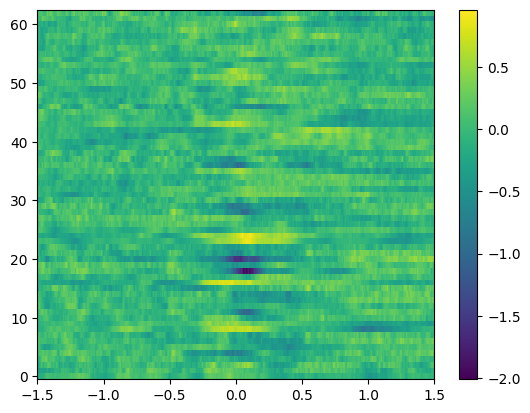

In [95]:
# plot mean ERP across electrodes
pmesh = plt.pcolormesh(t, np.arange(0, 63), np.mean(events-car,axis=2).T)
plt.colorbar(pmesh)

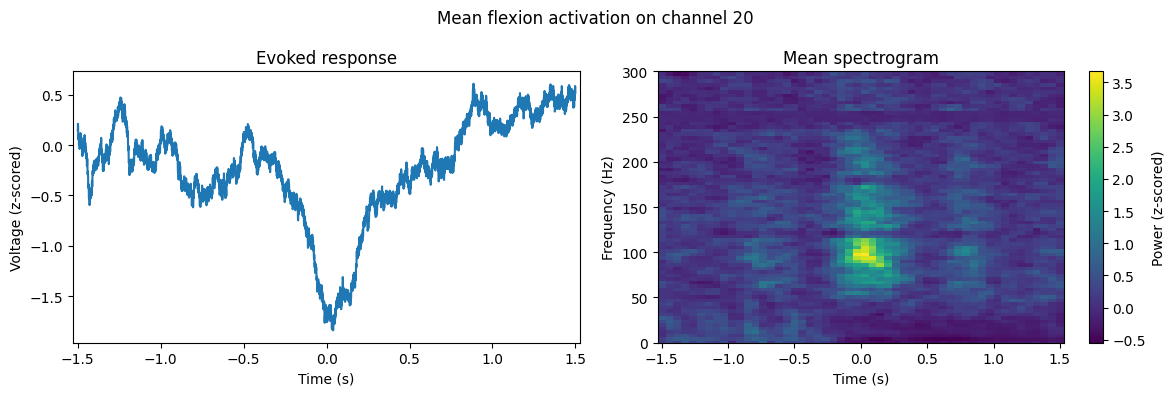

In [147]:
fig, ax = plt.subplots(1,2, sharex=True, figsize=(12, 4))
ax[0].plot(t, events_mean[:, plot_chan])
ax[0].set_ylabel('Voltage (z-scored)')
ax[0].set_xlabel('Time (s)')
ax[0].set_title('Evoked response')
pmesh = ax[1].pcolormesh(spec_events_t, freqs, spec_mean[:,:,plot_chan].T)
ax[1].set_ylim(0, 300)
ax[1].set_ylabel('Frequency (Hz)')
ax[1].set_xlabel('Time (s)')
ax[1].set_title('Mean spectrogram')
cbar = plt.colorbar(pmesh)
cbar.set_label('Power (z-scored)')
fig.suptitle('Mean flexion activation on channel {}'.format(plot_chan))
fig.tight_layout()


In [215]:
print(events.shape)
events_none = events[0,1,:]

(3000, 63, 47)

In [216]:
spec_events.shape

(52, 129, 63, 47)

In [184]:
spec_events[:,:,plot_chan,tr].shape

(52, 129)

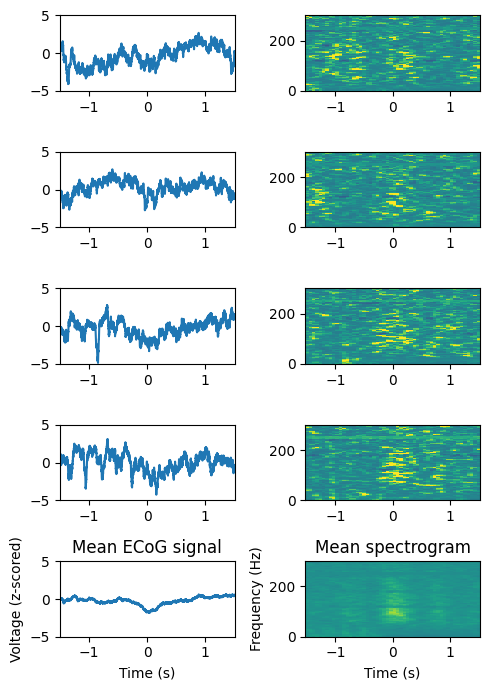

In [203]:
examp_trials = np.array([0, 1, 2, 3])
z_range = 5
mos_layout = [['ecog1', 'spec1'], ['ecog2', 'spec2'], ['ecog3', 'spec3'], ['ecog4', 'spec4'], ['ecog_mean', 'spec_mean']]
fig, ax = plt.subplot_mosaic(mos_layout, figsize=(5, 7))
for i, tr in enumerate(examp_trials):
    ax['ecog{}'.format(i+1)].plot(t, events[:, plot_chan, tr])    
    ax['ecog{}'.format(i+1)].set_ylim(-z_range, z_range)
    ax['ecog{}'.format(i+1)].set_xlim(-1.5, 1.5)
    ax['spec{}'.format(i+1)].pcolormesh(spec_events_t, freqs, spec_events[:,:,plot_chan,tr].T, vmin=-z_range, vmax=z_range)
    ax['spec{}'.format(i+1)].set_ylim(0, 300)


ax['ecog_mean'].plot(t, np.mean(events[:, plot_chan, :], axis=1))
ax['spec_mean'].pcolormesh(spec_events_t, freqs, np.mean(spec_events[:,:,plot_chan,:], axis=2).T, vmin=-z_range, vmax=z_range)
ax['ecog_mean'].set_ylim(-z_range, z_range)
ax['ecog_mean'].set_xlim(-1.5, 1.5)

ax['ecog_mean'].set_ylabel('Voltage (z-scored)')
ax['ecog_mean'].set_xlabel('Time (s)')
ax['ecog_mean'].set_title('Mean ECoG signal')
ax['spec_mean'].set_ylim(0, 300)
ax['spec_mean'].set_ylabel('Frequency (Hz)')
ax['spec_mean'].set_xlabel('Time (s)')
ax['spec_mean'].set_title('Mean spectrogram')
fig.tight_layout()

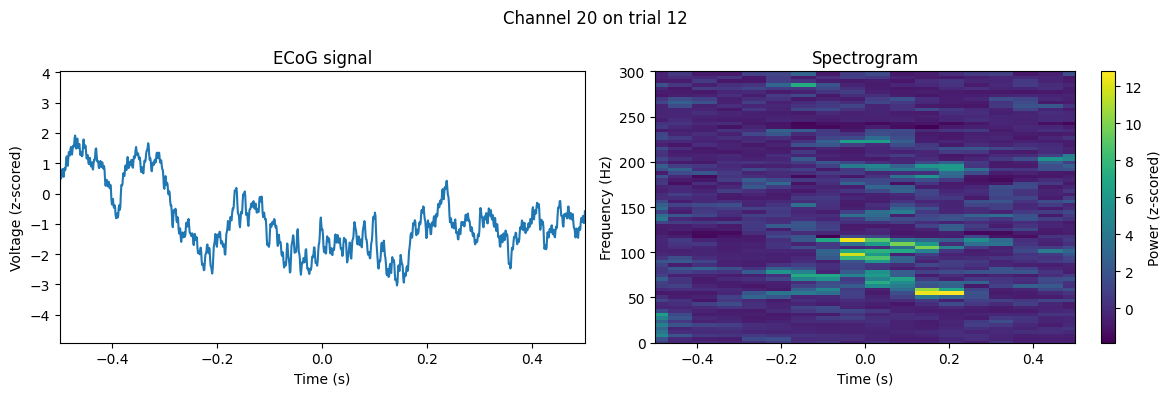

In [158]:
fig, ax = plt.subplots(1,2, sharex=True, figsize=(12, 4))
ax[0].plot(t, events[:, plot_chan, plot_trial])
ax[0].set_title('ECoG signal')
ax[0].set_ylabel('Voltage (z-scored)')
ax[0].set_xlabel('Time (s)')
ax[0].set_xlim(-0.5,0.5)
pmesh = ax[1].pcolormesh(spec_events_t, freqs, spec_events[:,:,plot_chan,plot_trial].T)
ax[1].set_ylim(0, 300)
ax[1].set_ylabel('Frequency (Hz)')
ax[1].set_xlabel('Time (s)')
ax[1].set_title('Spectrogram')
cbar = plt.colorbar(pmesh)
cbar.set_label('Power (z-scored)')
fig.suptitle('Channel {} on trial {}'.format(plot_chan,plot_trial))
fig.tight_layout()

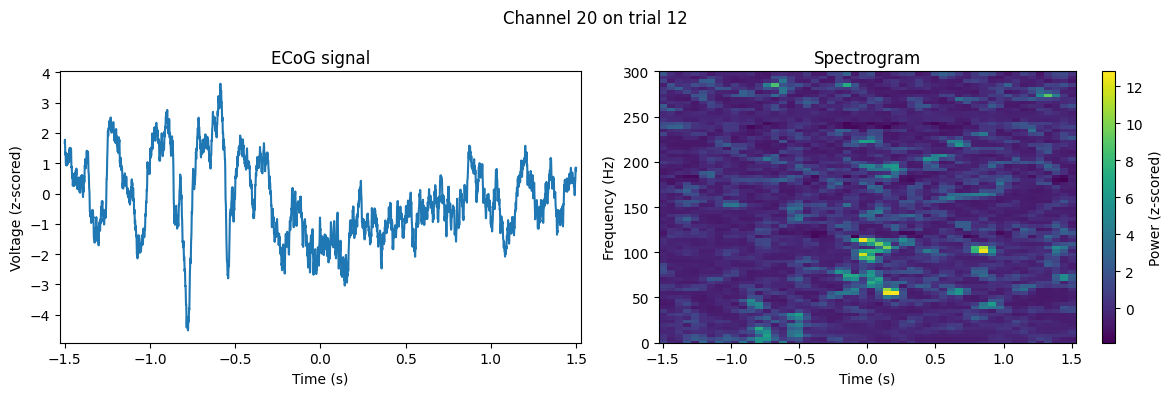

In [148]:
fig, ax = plt.subplots(1,2, sharex=True, figsize=(12, 4))
ax[0].plot(t, events[:, plot_chan, plot_trial])
ax[0].set_title('ECoG signal')
ax[0].set_ylabel('Voltage (z-scored)')
ax[0].set_xlabel('Time (s)')
pmesh = ax[1].pcolormesh(spec_events_t, freqs, spec_events[:,:,plot_chan,plot_trial].T)
ax[1].set_ylim(0, 300)
ax[1].set_ylabel('Frequency (Hz)')
ax[1].set_xlabel('Time (s)')
ax[1].set_title('Spectrogram')
cbar = plt.colorbar(pmesh)
cbar.set_label('Power (z-scored)')
fig.suptitle('Channel {} on trial {}'.format(plot_chan,plot_trial))
fig.tight_layout()


Text(0.5, 1.0, 'Power in 50-150 Hz')

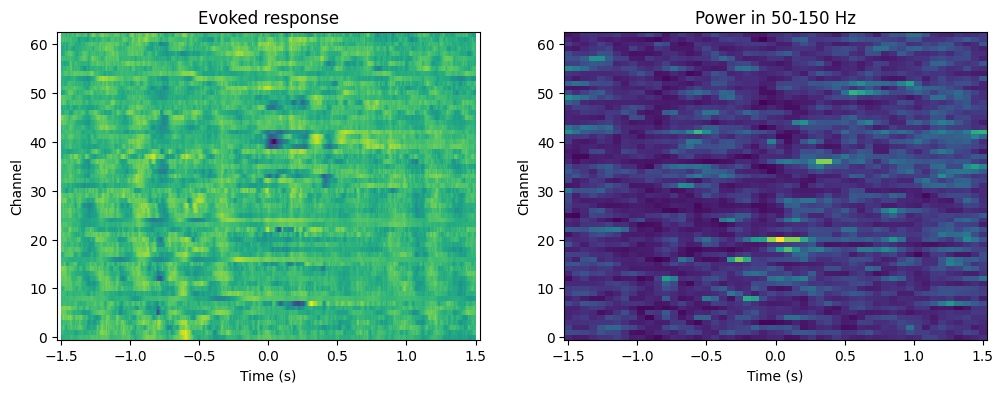

In [159]:
# plot ERP for specific trials
f_inds = np.where((freqs>50) & (freqs<150))[0]
fig, ax = plt.subplots(1,2, sharex=True, figsize=(12, 4))
ax[0].pcolormesh(t, ch_list, events[:,:,plot_trial].T)
ax[0].set_ylabel('Channel')
ax[0].set_xlabel('Time (s)')
ax[0].set_title('Evoked response')
ax[1].pcolormesh(spec_events_t, ch_list, np.mean(spec_events[:,f_inds,:,plot_trial],axis=0).T)
ax[1].set_ylabel('Channel')
ax[1].set_xlabel('Time (s)')
ax[1].set_title('Power in 50-150 Hz')

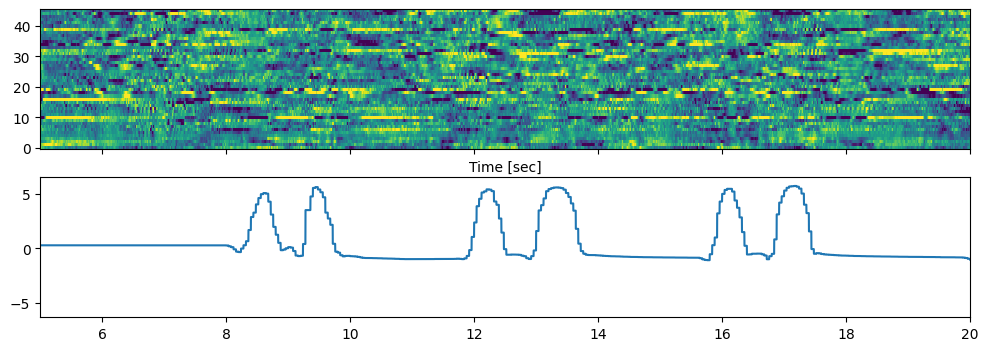

In [124]:
t_flex = np.arange(0, ecog['flex'].shape[0])/fs
# plot the spectrogram
fig, ax = plt.subplots(2,1,figsize=(12, 4),sharex=True)
# image plot of ecog multichannel data
ax[0].pcolormesh(t_flex, np.arange(0, ecog['data'].shape[1]), zscore(ecog['data'].T, 0), vmin=-2, vmax=2)
#ax[0].pcolormesh(times, freqs, zscore(np.log10(Sxx), 1), vmin=-2, vmax=2)
#ax[0].set_ylabel('Frequency [Hz]')
ax[0].set_xlabel('Time [sec]')
#ax[0].set_ylim(0, 100)
ax[0].set_xlim(5, 20)
ax[1].plot(t_flex, zscore(ecog['flex'][:, 4], 0))
plt.show()
